# Reproduce Staley (2016) Results

Based on the calculations in the USGS Emergency Debris Flow Assessment database (https://landslides.usgs.gov/hazards/postfire_debrisflow/), the Intensity I15 is transformed into the total accumulation during the 15 minutes, i.e. I15/4.  This is the same as the value stored in the column "Acc015_mm".

In [1]:
import pandas as pd
pd.set_option("max_colwidth", None)

In [2]:
import sklearn
import numpy as np

In [3]:
xl=pd.ExcelFile("../data/ofr20161106_appx-1.xlsx")
desc=xl.parse(xl.sheet_names[0])
modelData=xl.parse(xl.sheet_names[1])

In [4]:
modelData.columns

Index(['Fire Name', 'Year', 'Fire_ID', 'Fire_SegID', 'Database', 'State',
       'UTM_Zone', 'UTM_X', 'UTM_Y', 'Response', 'StormDate', 'GaugeDist_m',
       'StormStart', 'StormEnd', 'StormDur_H', 'StormAccum_mm',
       'StormAvgI_mm/h', 'Peak_I15_mm/h', 'Peak_I30_mm/h', 'Peak_I60_mm/h',
       'ContributingArea_km2', 'PropHM23', 'dNBR/1000', 'KF', 'Acc015_mm',
       'Acc030_mm', 'Acc060_mm'],
      dtype='object')

In [5]:
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

In [6]:
def get_scores(trues, preds):
    scores=[func(trues, preds) for func in [accuracy_score, jaccard_score, f1_score, roc_auc_score]]
    return scores

def get_scoredf(TrTr, TrPr, TeTr, TePr):
    train_scores=get_scores(TrTr, TrPr)
    test_scores=get_scores(TeTr, TePr)
    
    scoredf=pd.DataFrame({"Training": train_scores, "Test": test_scores}, index=["Accurary", "Jaccard", "F1", "AUC"])
    return scoredf

In [7]:
modelData.columns

Index(['Fire Name', 'Year', 'Fire_ID', 'Fire_SegID', 'Database', 'State',
       'UTM_Zone', 'UTM_X', 'UTM_Y', 'Response', 'StormDate', 'GaugeDist_m',
       'StormStart', 'StormEnd', 'StormDur_H', 'StormAccum_mm',
       'StormAvgI_mm/h', 'Peak_I15_mm/h', 'Peak_I30_mm/h', 'Peak_I60_mm/h',
       'ContributingArea_km2', 'PropHM23', 'dNBR/1000', 'KF', 'Acc015_mm',
       'Acc030_mm', 'Acc060_mm'],
      dtype='object')

In [8]:
usecols=["Acc015_mm",
         "PropHM23",
         "dNBR/1000",
         "KF",
         "Response"]

usecols = usecols + ["Database"]

In [9]:
cdata=modelData[usecols].copy()
cdata=cdata.dropna()
len(cdata)

1243

Adjusting unrealistic $K_f$ values - commented out, as it's not sure if Staley did this:

In [10]:
#mask=cdata["KF"] > 0.64
#cdata.loc[mask,"KF"] = cdata["KF"].median()

In [11]:
#computing input data just as in Staley'16

cdata["PropHM23_x_i15"] = cdata["PropHM23"] * cdata["Acc015_mm"]
cdata["dNBR_x_i15"] = cdata["dNBR/1000"] * cdata["Acc015_mm"]
cdata["KF_x_i15"] = cdata["KF"] * cdata["Acc015_mm"]

In [12]:
usecols2=["PropHM23_x_i15","dNBR_x_i15", "KF_x_i15"]

In [13]:
cdata

,Acc015_mm,PropHM23,dNBR/1000,KF,Response,Database,PropHM23_x_i15,dNBR_x_i15,KF_x_i15
0,0.80,0.217933,0.297853,0.250000,0,Training,0.174346,0.238282,0.200000
1,0.80,0.061249,0.224896,0.250000,0,Training,0.048999,0.179916,0.200000
2,0.80,0.042968,0.065537,0.248541,0,Training,0.034374,0.052430,0.198832
3,0.40,0.092164,0.141711,0.250000,0,Training,0.036866,0.056684,0.100000
4,0.40,0.058353,0.210158,0.250000,0,Training,0.023341,0.084063,0.100000
...,...,...,...,...,...,...,...,...,...
1545,3.50,0.009801,0.187053,0.000000,0,Test,0.034302,0.654684,0.000000
1546,15.75,0.001571,0.500223,0.000000,0,Test,0.024740,7.878512,0.000000
1547,7.25,0.001571,0.500223,0.000000,0,Test,0.011388,3.626616,0.000000
1548,6.25,0.001571,0.500223,0.000000,0,Test,0.009817,3.126394,0.000000


In [14]:
trainX=cdata.query("Database == 'Training'")[usecols2]
trainY=cdata.query("Database == 'Training'")["Response"]

testX=cdata.query("Database == 'Test'")[usecols2]
testY=cdata.query("Database == 'Test'")["Response"]

### 1. Logistic Regression

In [15]:
clfl = LogisticRegression(random_state=0, penalty='l2').fit(trainX, trainY)
lr_trainYp=clfl.predict(trainX)
lr_testYp=clfl.predict(testX)

scoredf_lr=get_scoredf(trainY, lr_trainYp, testY, lr_testYp)
scoredf_lr

,Training,Test
Accurary,0.833129,0.647196
Jaccard,0.411255,0.386179
F1,0.582822,0.557185
AUC,0.711888,0.703778


### 2.  Random Forest Classifier

In [16]:
clfl = RandomForestClassifier(random_state=0).fit(trainX, trainY)
rf_trainYp=clfl.predict(trainX)
rf_testYp=clfl.predict(testX)

scoredf_lr=get_scoredf(trainY, rf_trainYp, testY, rf_testYp)
scoredf_lr

,Training,Test
Accurary,1.0,0.581776
Jaccard,1.0,0.353791
F1,1.0,0.522667
AUC,1.0,0.667301


### 3. KNeighbors Classifier

In [17]:
clfl = KNeighborsClassifier().fit(trainX, trainY)
knn_trainYp=clfl.predict(trainX)
knn_testYp=clfl.predict(testX)

scoredf_lr=get_scoredf(trainY, knn_trainYp, testY, knn_testYp)
scoredf_lr

,Training,Test
Accurary,0.871166,0.600467
Jaccard,0.556962,0.337209
F1,0.715447,0.504348
AUC,0.799042,0.649826


### 4. Decision Tree Classifier

In [18]:
clfl = DecisionTreeClassifier(random_state=0).fit(trainX, trainY)
dt_trainYp=clfl.predict(trainX)
dt_testYp=clfl.predict(testX)

scoredf_lr=get_scoredf(trainY, dt_trainYp, testY, dt_testYp)
scoredf_lr

,Training,Test
Accurary,1.0,0.544393
Jaccard,1.0,0.313380
F1,1.0,0.477212
AUC,1.0,0.616988


### 5. Neural Network

In [19]:
clfl = MLPClassifier(hidden_layer_sizes=(30, 30, 30), max_iter=1000).fit(trainX, trainY)
nn_trainYp=clfl.predict(trainX)
nn_testYp=clfl.predict(testX)

scoredf_lr=get_scoredf(trainY, nn_trainYp, testY, nn_testYp)
scoredf_lr

,Training,Test
Accurary,0.836810,0.591121
Jaccard,0.454918,0.339623
F1,0.625352,0.507042
AUC,0.741103,0.651688


In [20]:
# Calculate ROC curve and AUC
lr_fpr, lr_tpr, _ = roc_curve(testY, lr_testYp)
lr_auc = auc(lr_fpr, lr_tpr)

rf_fpr, rf_tpr, _ = roc_curve(testY, rf_testYp)
rf_auc = auc(rf_fpr, rf_tpr)

knn_fpr, knn_tpr, _ = roc_curve(testY, knn_testYp)
knn_auc = auc(knn_fpr, knn_tpr)

dt_fpr, dt_tpr, _ = roc_curve(testY, dt_testYp)
dt_auc = auc(dt_fpr, dt_tpr)

nn_fpr, nn_tpr, _ = roc_curve(testY, nn_testYp)
nn_auc = auc(nn_fpr, nn_tpr)

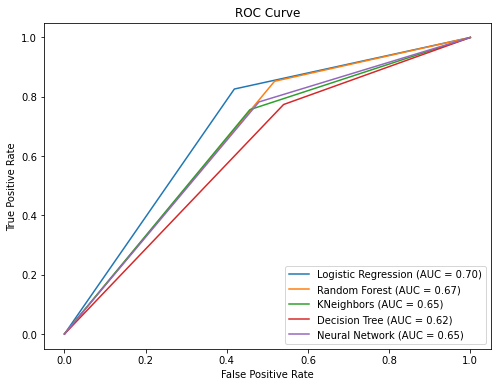

In [23]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(knn_fpr, knn_tpr, label=f'KNeighbors (AUC = {knn_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.2f})')
# plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()